In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/textiledefectdetection/train64.h5
/kaggle/input/textiledefectdetection/matchingtDATASET_test_32.h5
/kaggle/input/textiledefectdetection/test32.csv
/kaggle/input/textiledefectdetection/train32.csv
/kaggle/input/textiledefectdetection/test32.h5
/kaggle/input/textiledefectdetection/train32.h5
/kaggle/input/textiledefectdetection/test64.csv
/kaggle/input/textiledefectdetection/matchingtDATASET_train_32.h5
/kaggle/input/textiledefectdetection/matchingtDATASET_test_64.h5
/kaggle/input/textiledefectdetection/matchingtDATASET_train_64.h5
/kaggle/input/textiledefectdetection/test64.h5
/kaggle/input/textiledefectdetection/train64.csv


In [2]:
!git clone 'https://gist.github.com/d6e801ecf19449029decb5b68dd6280a.git' custom_loss
!git clone 'https://gist.github.com/belkhir-nacim/10a0ce966159eddc6a0cae07c92acdc8' utils
!pip install torchsummary
import gc
import os,h5py
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn,optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
from torchsummary import summary
from custom_loss.ssim_loss import SSIM
from utils.cudafy import Cudafy
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

Cloning into 'custom_loss'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (6/6), 1.22 KiB | 416.00 KiB/s, done.
Cloning into 'utils'...
remote: Enumerating objects: 5, done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 5
Unpacking objects: 100% (5/5), 805 bytes | 805.00 KiB/s, done.


In [3]:
EXAMPLE_DATA_ROOT_FOLDER = '/kaggle/input/textiledefectdetection'

In [4]:
class UnsupervisedTextureDataset(Dataset):
    filenames = {64: dict(train='matchingtDATASET_train_64.h5', test='matchingtDATASET_test_64.h5'),
                 32: dict(train='matchingtDATASET_train_32.h5', test='matchingtDATASET_test_32.h5')}
    
    defect_classes = ['good', 'color','cut','hole','metal_contamination','thread']
    
    def __init__(self, root_folder, train=True, patch_size=64, keep_angles=True, keep_defects=False, transformation=None, test_sub_sample=200):
        if os.path.exists(root_folder):
            self.root_folder = root_folder
        else:
            raise IOError('The path of the directory is incorrect or doesn\'t exist')
        
        self.patch_size = patch_size if patch_size in self.filenames.keys() else 32    
        self.data_dict, self.label_defect, self.label_angles, self.index_image = self.load_data(train,keep_angles=keep_angles,keep_defects=keep_defects)
        assert(type(keep_angles) is bool or ((type(keep_angles) is int) and (keep_angles <=8)) )
        self.keep_angles = keep_angles
        self.transformation = transforms.Compose([transforms.ToTensor()]) if transformation is None  else  transformation
        if (train==False) and (test_sub_sample is not None):
            test_sub_sample = int(test_sub_sample)
            if test_sub_sample>1:
                idx = np.random.choice( np.arange(self.label_angles.shape[0]), size=test_sub_sample,replace=False)
                self.label_defect, self.label_angles, self.index_image = self.label_defect[idx], self.label_angles[idx], self.index_image[idx]
            
    def load_data(self,train, keep_angles=True, keep_defects=False):
        files = self.filenames[self.patch_size]
        filename = files['train'] if train else files['test']
        label_defect, label_angle, index_image = [], [], []
        with h5py.File(os.path.join(self.root_folder,filename),mode='r') as f:
            dict_defects = {}
            for defect_key in f.keys():
                if not keep_defects and not defect_key=='good':
                    continue
                DONE=False
                dict_angles = {}
                for angle_key in f[defect_key].keys():
                    if not keep_angles and angle_key==0:
                        continue
                    x = f[defect_key][angle_key][:]
                    if not DONE:
                        label_angle.extend([int(angle_key.replace('angle',''))]*x.shape[0])
                        label_defect.extend([int(self.defect_classes.index(defect_key))]*x.shape[0])
                        index_image.append(np.arange(x.shape[0]))
                        DONE=True
                    dict_angles[int(angle_key.replace('angle',''))] = x.reshape(x.shape[0], self.patch_size,self.patch_size,1)
                dict_defects[int(self.defect_classes.index(defect_key))] = dict_angles
        return dict_defects, np.array(label_defect),np.array(label_angle),np.concatenate(index_image)
    
    def __len__(self):
        return self.label_defect.shape[0]
    
    def __getitem__(self,idx):
        angles = self.data_dict[self.label_defect[idx]]
        img =angles[0][self.index_image[idx]]
        img = self.transformation(img)        
        if not self.keep_angles:
            return img, img
        else:
            imgrot =angles[self.keep_angles][self.index_image[idx]]
            imgrot = self.transformation(imgrot)
            return img, imgrot
        
        
def getdataloader(root, patch_size=64, batch_size=32, keep_angles=False,keep_defects=False,  test_sub_sample=False, num_workers=5, *args,**kwargs):
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.3541], [0.1352])])
    dataset = UnsupervisedTextureDataset(root_folder=root, train=True, patch_size=patch_size, keep_angles=keep_angles, keep_defects=keep_defects, transformation=transformation)
    train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers, pin_memory=True)
    
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.3541], [0.1352])])
    dataset = UnsupervisedTextureDataset(root_folder=root, train=False, patch_size=patch_size,  keep_angles=keep_angles, keep_defects=keep_defects, transformation=transformation, test_sub_sample=test_sub_sample)
    val_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader

def gettestdata(root, patch_size=64, batch_size=128, keep_angles=False, keep_defects=True, test_sub_sample=None, num_workers=5, *args, **kwargs):
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.3541], [0.1352])])
    dataset = UnsupervisedTextureDataset(root_folder=root, train=False, patch_size=patch_size, keep_angles=keep_angles, keep_defects=keep_defects, transformation=transformation, test_sub_sample=test_sub_sample)
    val_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    return val_loader
    

In [5]:
class FullyConnectedAE(nn.Module):
    ttype = 'ae'
    def __init__(self,img_shape=None, encoding_dim=64, *args,**kwargs):
        super(FullyConnectedAE, self).__init__()
        self.input_shape = img_shape
        self.input_dim = img_shape[0]* img_shape[1]
        self.encoder = nn.Linear(self.input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, self.input_dim)
    def forward(self, x):
        x = x.view(x.shape[0],-1)
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return torch.sigmoid(decoded.view(x.shape[0],1, *self.input_shape))
    
    def features_extraction(self,x):
        x = x.view(x.shape[0],-1)
        encoded = F.relu(self.encoder(x))
        return encoder

In [6]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) + torch.sum(self._embedding.weight**2, dim=1) - 2 * torch.matmul(flat_input, self._embedding.weight.t()))    
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
    
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)  + torch.sum(self._embedding.weight**2, dim=1) - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + (1 - self._decay) * torch.sum(encodings, 0)
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = ( (self._ema_cluster_size + self._epsilon) / (n + self._num_embeddings * self._epsilon) * n)
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings
    

class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(nn.ReLU(True), nn.Conv2d(in_channels=in_channels,out_channels=num_residual_hiddens, kernel_size=3, stride=1, padding=1, bias=False),
                                    nn.ReLU(True), nn.Conv2d(in_channels=num_residual_hiddens, out_channels=num_hiddens, kernel_size=1, stride=1, bias=False))
    def forward(self, x):
        return x + self._block(x)

class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens) for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)
    

class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()
        self._conv_1 = nn.Conv2d(in_channels=in_channels,out_channels=num_hiddens//2,kernel_size=4,stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,out_channels=num_hiddens,kernel_size=4,stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,out_channels=num_hiddens,kernel_size=3,stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,num_hiddens=num_hiddens,num_residual_layers=num_residual_layers,num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        x = self._conv_2(x)
        x = F.relu(x)
        x = self._conv_3(x)
        return self._residual_stack(x)
    
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        self._conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=num_hiddens, kernel_size=3, stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens, num_hiddens=num_hiddens, num_residual_layers=num_residual_layers, num_residual_hiddens=num_residual_hiddens)
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,  out_channels=num_hiddens//2, kernel_size=4,  stride=2, padding=1)
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,  out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = self._residual_stack(x)
        x = self._conv_trans_1(x)
        x = F.relu(x)
        return self._conv_trans_2(x)
    
class VQVAEModel(nn.Module):
    ttype = 'vqvae'
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(VQVAEModel, self).__init__()
        self._encoder = Encoder(1, num_hiddens,num_residual_layers,  num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1,  stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self._decoder = Decoder(embedding_dim, num_hiddens, num_residual_layers, num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [7]:
class Trainer(object):
    def __init__(self, model, train_loader, val_loader,optimizer=None, criterion=None, no_epochs=5, cudafy=None, target_type='defect', lr=1e-1, *args,**kwargs):
        
        self.cudafy = cudafy if cudafy is not None else Cudafy(0)
        self.no_epochs = no_epochs
        self.model = self.cudafy(model)
        self.criterion = criterion #if criterion is not None else nn.MSELoss()

        if self.criterion.__class__.__name__!= 'SSIM':
            print('not ssim')
        else:
            print('ssim')
        if optimizer == optim.Adam:
            self.optimizer = optimizer(self.model.parameters(),lr=lr, amsgrad=False) # if optimizer is not None else optim.SGD(self.model.parameters(), lr=lr)
        else:
            self.optimizer = optimizer(self.model.parameters(),lr=lr)
        self.train_loader, self.valid_loader = train_loader, val_loader
        print("Total_params",sum(p.numel() for p in model.parameters()))
        print("Trainable_params",sum(p.numel() for p in model.parameters() if p.requires_grad))
        self.data_variance = 0.1352 # computed on all training healthy data
    
    def train_an_epoch(self):
        self.model.train()
        train_loss = 0.0
        for data,target in self.train_loader:
            data, target = self.cudafy(data), self.cudafy(target)
            # clear the gradients of all optimized variables
            self.optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            if self.model.ttype =='ae':
                output = self.model(data)
                loss = self.criterion(output, target) if self.criterion.__class__.__name__!= 'SSIM' else  1 - self.criterion(output,target)
            elif self.model.ttype == 'vqvae':
                vq_loss, data_recon, perplexity = self.model(data)
                recon_error = F.mse_loss(data_recon, target) / self.data_variance
                loss = recon_error + vq_loss
            # calculate the batch loss
            
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            self.optimizer.step()
            # update training loss
            train_loss += self.cudafy.get(loss).item()*data.size(0)
        return train_loss
            
    def valid_an_epoch(self):
        valid_loss = 0.0
        self.model.eval()
        for data,target in self.valid_loader:
            data, target = self.cudafy(data), self.cudafy(target)
            if self.model.ttype =='ae':
                output = self.model(data)
                loss = self.criterion(output, target) if self.criterion.__class__.__name__!= 'SSIM' else 1 - self.criterion(output,target)
            elif self.model.ttype == 'vqvae':
                vq_loss, data_recon, perplexity = self.model(data)
                recon_error = F.mse_loss(data_recon, target) / self.data_variance
                loss = recon_error + vq_loss
            # update average validation loss
            valid_loss += self.cudafy.get(loss).item()*data.size(0)            
        return valid_loss
    
    
    def train(self):
        alltrainloss = []
        allvalidloss = []
#         pbar = tqdm()
        iterable = range(1, self.no_epochs+1)
        for epoch in iterable:

            train_loss = self.train_an_epoch()
            valid_loss = self.valid_an_epoch()
            train_loss = train_loss/len(self.train_loader.sampler)
            valid_loss = valid_loss/len(self.valid_loader.sampler)
            gc.collect()
            
            alltrainloss.append(train_loss)
            allvalidloss.append(valid_loss)
            # print training/validation statistics 
#             pbar.set_description(f'Epoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
            print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}', end='\n' if epoch%10==0 else '\r')
#             pbar.update(1)
        figure = plt.figure(figsize=(10,10))
        ax1 = figure.gca()
        linet, = ax1.plot(alltrainloss,label='Train')
        linev, = ax1.plot(allvalidloss,label='Valid')
        ax1.legend([linet,linev],['train','valid'])

In [8]:
def get_model(modeltype='fullyae', patch_size=32, encoding_dim=64, num_hiddens = 128,  num_residual_hiddens = 32, num_residual_layers = 2, embedding_dim = 64, num_embeddings = 512, commitment_cost = 0.25, decay = 0.99, *args,**kwargs):
    if modeltype=='fullyae': model = FullyConnectedAE(img_shape=(patch_size, patch_size), encoding_dim=encoding_dim)
    elif modeltype=='convae': model = ConvAE()
    elif modeltype=='vqvae': model = VQVAEModel(num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay)
        
    else:
        raise NotImplementedError('More Options will be added later')
    return model

def run(options):
    train_loader, val_loader = getdataloader(**options)        
    model = get_model(**options)
#     summary(model, (1,options['patch_size'],options['patch_size']),1,'cpu')
    trainer = Trainer(model=model,train_loader=train_loader, val_loader=val_loader, **options)
    trainer.train()
    gc.collect()
    return trainer.model

def test(options, model):
    cudafy = options['cudafy']
    model = cudafy(model)
    valid_loader = gettestdata(**options)
    with torch.no_grad():
        model.eval()
        for data,target in valid_loader:
            data, target = cudafy(data), cudafy(target)
            if model.ttype =='ae':
                output = model(data)
            elif model.ttype == 'vqvae':
                _, output, _ = model(data)

            fig, axes = plt.subplots(1,2, figsize=(25,25))
            ax1, ax3 = axes.ravel()
            grid_img = make_grid(cudafy.get(data),nrow=16).permute(1, 2, 0)*0.1352 +       0.3541
            ax1.imshow(grid_img)
            ax1.set_title('Input')
            grid_img = make_grid(cudafy.get(output),nrow=16).permute(1, 2, 0) *0.1352 +       0.3541
            ax3.imshow(grid_img)
            ax3.set_title('Reconstructed')

not ssim
Total_params 173345
Trainable_params 173345
Epoch: 10 	Training Loss: 10.5585 	Validation Loss: 11.0489
Epoch: 20 	Training Loss: 10.5027 	Validation Loss: 10.6900
Epoch: 30 	Training Loss: 10.7119 	Validation Loss: 10.5548
Epoch: 40 	Training Loss: 10.7535 	Validation Loss: 10.5568
Epoch: 50 	Training Loss: 9.6270 	Validation Loss: 9.4763
Epoch: 60 	Training Loss: 9.4566 	Validation Loss: 9.8592
Epoch: 70 	Training Loss: 10.0331 	Validation Loss: 10.2302
Epoch: 80 	Training Loss: 8.5545 	Validation Loss: 8.0998
Epoch: 90 	Training Loss: 8.7506 	Validation Loss: 10.3208
Epoch: 100 	Training Loss: 3.0992 	Validation Loss: 2.9557
Epoch: 110 	Training Loss: 1.6757 	Validation Loss: 1.6299
Epoch: 120 	Training Loss: 1.1099 	Validation Loss: 1.1184
Epoch: 130 	Training Loss: 0.8812 	Validation Loss: 0.8855
Epoch: 140 	Training Loss: 0.7481 	Validation Loss: 0.7660
Epoch: 150 	Training Loss: 0.6898 	Validation Loss: 0.7108
Epoch: 160 	Training Loss: 0.6561 	Validation Loss: 0.6770
E

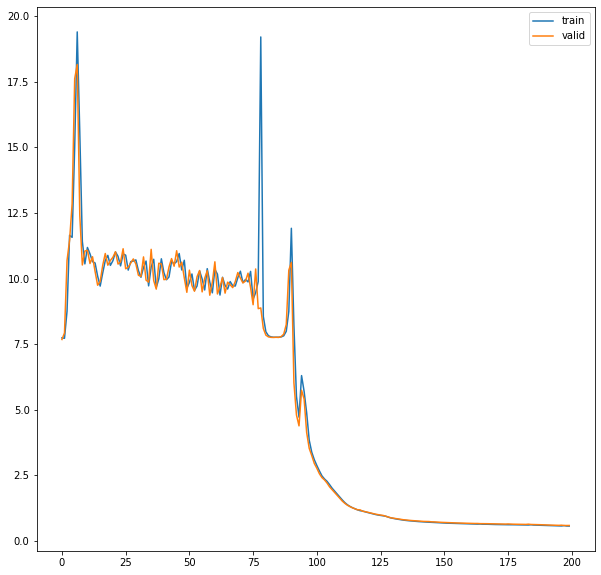

In [9]:
train_parameters=dict(root='/kaggle/input/textiledefectdetection', patch_size=64, batch_size=256, modeltype='vqvae',
                      num_hiddens = 64,  num_residual_hiddens = 32, num_residual_layers = 1, embedding_dim = 32, num_embeddings = 128, commitment_cost = 0.25, decay = 0.99,
                      cudafy = Cudafy(0), lr=1e-3, no_epochs=200,  keep_angles=False,  keep_defects=False, test_sub_sample=500, num_workers=4, optimizer= optim.Adam)
model = run(train_parameters)

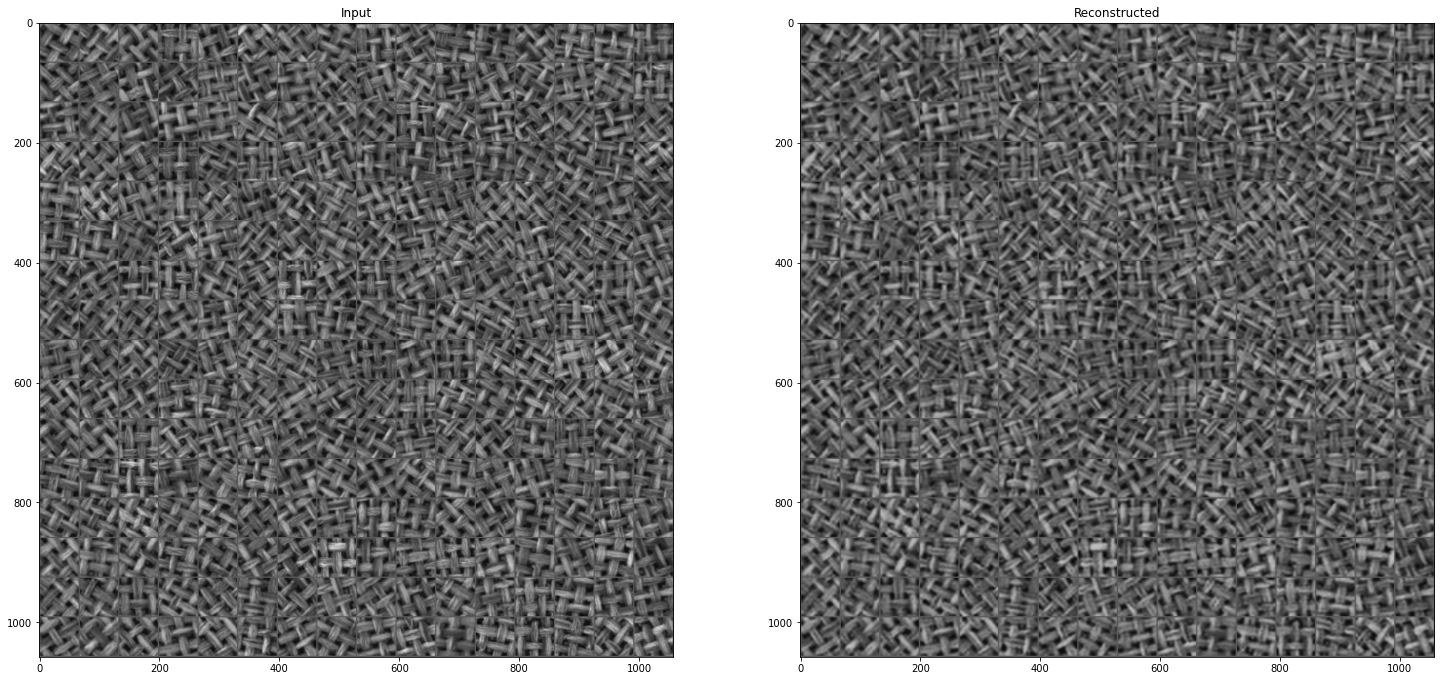

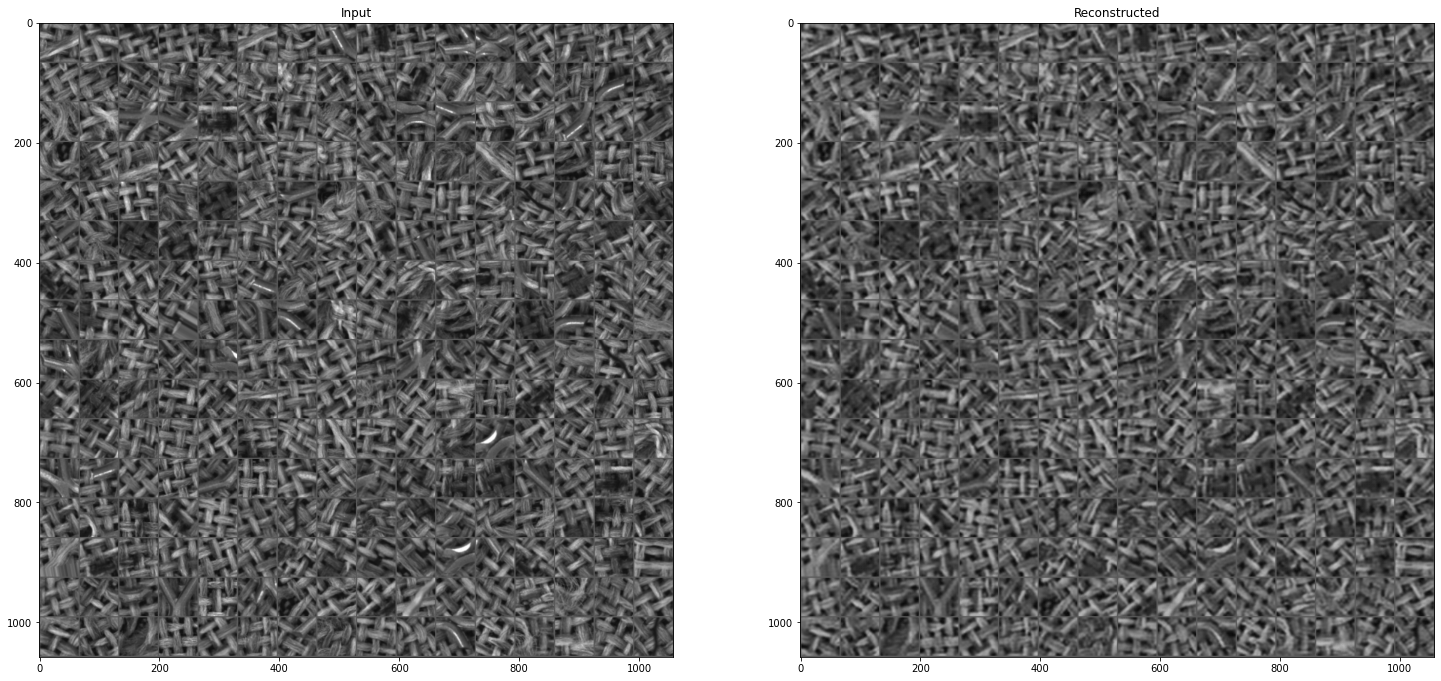

In [10]:
test_parameters = dict(root='/kaggle/input/textiledefectdetection', patch_size=64, batch_size=256, cudafy=Cudafy(0),keep_angles=False, keep_defects=False, num_workers=4,test_sub_sample=256  )
test(options=test_parameters, model=model)
test_parameters = dict(root='/kaggle/input/textiledefectdetection', patch_size=64, batch_size=256, cudafy=Cudafy(0),keep_angles=False, keep_defects=True, num_workers=4,test_sub_sample=256  )
test(options=test_parameters, model=model)

In [11]:
def gen_img_from_discrete_code(code, id_img_to_plot=0):
    '''
    code: B,outH,outW, where outH is the output size of the encoder
    id_img_to_plot: id of the img to plot in the batch, should be less than B
    '''
    z_idx=model._vq_vae._embedding(code).permute(0, 3, 1, 2)
    out_img=model._decoder(z_idx)
    plt.figure()
    plt.imshow(out_img[id_img_to_plot].cpu().detach().squeeze(), cmap='gray')
    plt.title('img generated from discrete code')

def test_image_generator():
    valid_loader = gettestdata(**test_parameters)
    data, tgt=next(iter(valid_loader))
    tensor_img=torch.tensor(data).cuda()

    #######test generation manually########
    id_img_to_plot=0
    plt.imshow(tensor_img[id_img_to_plot].cpu().detach().squeeze(), cmap='gray')
    plt.title('input img')
    out_e=model._pre_vq_conv(model._encoder(tensor_img))
    B,C,H,W=out_e.shape
    code=torch.argmax(model._vq_vae(out_e)[-1], dim=1).reshape(B,H,W)
    gen_img_from_discrete_code(code, id_img_to_plot)
    ######################################
    #generate random discrete code
    ind=np.random.randint(0,train_parameters['num_embeddings'],(1,H,W)).astype(np.long)#encoder divdes size by 4#it should be between 0 and K-1
    ind_tensor=torch.LongTensor(ind).cuda()
    gen_img_from_discrete_code(ind_tensor, id_img_to_plot)